In [ ]:
### 4C16 Lab 7 - Self Driving Car

In [ ]:
### First!  Read https://github.com/frcs/EE4C16-self-driving-lab for more info.

### Second!  Read this carefully!

# In this lab you will train a neural net to drive a virtual driving simulator,
# using data recorded from your own manual operation of the sim.
#
# Your model will attempt to predict the correct steering angle, given the input
# images, using your recorded laps as training data.
#
# Your model will be operating in cruise control mode; it does not have any throttle
# input, and will not be able to reverse.
#
# Collecting Training Data
# ========================
# Step 1 is to run the simulator on your local machine (eg. within Windows, in the CADLab
#        or on your own computer) and drive around while recording training data (press 'R').  
#        For each timestep in your driving, three images are recorded: the center 
#        (straight ahead) view, and also left and right views.  
#        Your steering angle is also recorded.
#
# Step 2: You will zip the IMG directory and the driving_log.csv file into a zip file that you will 
#         name recordings.zip and upload this zip file to your Drive at 4c16-labs/data/recordings.zip 
#
# Step 3: In this notebook's VM, you will unzip recordings.zip to have a local copy
#
# Designing/Training the DNN
# ==========================
# Step 4: In the notebook, Design and train a DNN to predict the steering angle from an image
#
# Evaluation
# ==========
# Step 5: Download the model to your workstation and use it to pilot the car around the track ('autonomous mode')
#
# Step 6: You will upload the record of the car's positions back to your lab directory in Google Drive..
#
# Step 7: push for assessment
#
# You can repeat steps 3-7 when tweaking your network.
# You can also repeat step 1-3 if you decide you need more or more varied training data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-07/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/4c16-labs/code/lab-07


In [ ]:
# Import the necessary modules
import tensorflow as tf
import keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation 
from tensorflow.keras.layers import PReLU, LeakyReLU, Conv2D, Lambda, MaxPooling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import random
import ntpath
import csv
import PIL


In [ ]:
# Define some useful functions
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss (MSE)')
        plt.legend()
        plt.show();
        

In [ ]:
def import_csv_data(logfile):
    with open(logfile, 'r') as f:
        data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

    # Each row of the CSV contains the data from one timestep of the training recording.
    # Column semantics are as follows:
    center = 0   # Path (or filename) of image file containing center view
    left = 1     # Image file containing left view
    right = 2    # Image file containing right view
    angle = 3    # Desired orientation of car (steering angle)
    accel = 4    # Acceleration (throttle)
    stop = 5     # Not sure what this..
    speed = 6    # Speed

    # Condense the recorded data into a map of image files (input) to steering angle (output).
    # Note that in the simulation, when our NN-model is driving, it will be provided the 
    # only front image as input.
    parsed_data = dict()

    for row in data:  # 'row' is an array with values corresponding to columns in the CSV.
        # Skip examples with a quasi-static car.
        if float(row[speed]) < 0.01:
            continue  
        
        center_image = '/content/recordings/IMG/' + ntpath.basename(row[center])
        left_image = '/content/recordings/IMG/' + ntpath.basename(row[left])
        right_image = '/content/recordings/IMG/' + ntpath.basename(row[right])
        
        parsed_data[center_image] = float(row[angle])
        
        # This is a trick to maximize the data available.  Have a think about what is going on here...
        parsed_data[left_image] = float(row[angle]) + 0.20
        parsed_data[right_image] = float(row[angle]) - 0.20

    return parsed_data

In [ ]:
# At this point, you should have generated some training data on your local workstation 
# and copied it as a zip file onto your google drive at a place called 4c16-labs/data/recordings.zip

# Run this cell to extract the uploaded training data:
!rm -rf /content/recordings
!mkdir -p /content/recordings
!unzip -o -qq /content/gdrive/MyDrive/4c16-labs/data/recordings.zip -d /content/recordings
driving_log = '/content/recordings/driving_log.csv'
training_data = import_csv_data(driving_log)

('/content/recordings/IMG/center_2022_11_18_20_20_51_117.jpg', 0.0)


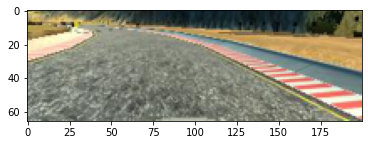

In [ ]:
def load_image(path_to_jpg):
    im = PIL.Image.open(path_to_jpg)
    im_width = im.size[0]
    im_height = im.size[1]
    
    # We are going to discard the sky and the car, to focus training on the road.
    # This crop isolates that portion.  You can see the effects by changing the values
    # and re-evaluating that cell, but they must match the original values (top=50, bottom=140)
    # when you train so as to match the input supplied from the simulator.
    left = 0
    right = im_width
    top = 50 # 0
    bottom = 140 # im_height
    
    im = im.crop((left, top, right, bottom))
    
    # We can shrink the image a bit to reduce training time.
    im = im.resize((200, 66), PIL.Image.BICUBIC)
    im = np.asarray(im)
    return im

A = next(iter(training_data.items()))
print(A)
im = load_image(A[0])
plt.imshow(im)


In [ ]:
def data_generator(training_data, batch_size, reject_above=True, reject_thresh=0.0):
    inputs_batch = []
    targets_batch = []
    
    while True:
        random.seed(42)
        for idx, (k, v) in enumerate(training_data.items()):
            sample = random.random()
            reject_item = ((sample > reject_thresh and reject_above) or
                        (sample <= reject_thresh and not reject_above))
            
            if not reject_item:
                decoded_image = load_image(k)
                # Important--as we've stressed before--to scale the input data to -1..1.
                decoded_image = 2.0*decoded_image/255 - 1
                label = v

                inputs_batch.append(decoded_image)
                targets_batch.append(label)

            if (len(inputs_batch)+1) % batch_size == 0:
                yield (np.asarray(inputs_batch), np.asarray(targets_batch))
                inputs_batch.clear()
                targets_batch.clear()


In [ ]:
# Define your model in this cell.
# See the paper 'End to End Learning for Self-Driving Cars' (Bojarski et al) for some ideas.

inputs = Input(shape=(66, 200, 3))
 
x = inputs
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'valid', strides=1)(inputs)
x = keras.layers.MaxPool2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'valid', strides=1)(x)
x = keras.layers.MaxPool2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'valid', strides=1)(x)
x = keras.layers.MaxPool2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.2)(x)

x = Flatten()(x)  # Don't flatten until after your 2D layers 
x = keras.layers.Dropout(0.2)(x)
x = Dense(128, activation=None)(x)
x = keras.layers.Dropout(0.2)(x)
output = Dense(1)(x)

model = keras.models.Model(inputs=inputs, outputs=output)
model.summary()
model.compile(optimizer='adam', loss='mse')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 198, 64)       1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 99, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 32, 99, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 97, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 48, 128)      0         
 2D)                                                       

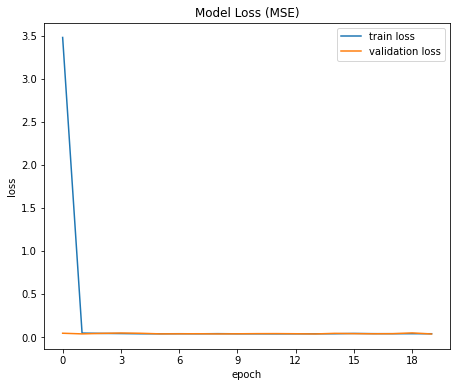

239/239 [==============================] - 39s 164ms/step - loss: 0.0374 - val_loss: 0.0346


In [ ]:
# Training.  Re-evaluate this cell repeatedly to train more.
batch_size = 64
validation_fraction = 0.1  # Probably best to leave this value alone...
model.fit_generator(
    generator=data_generator(training_data, batch_size=64, reject_above=False, reject_thresh=validation_fraction),
    validation_data=data_generator(training_data, batch_size=64, reject_above=True, reject_thresh=validation_fraction),
    steps_per_epoch=int((1-validation_fraction)*len(training_data))//batch_size,
    validation_steps=int(validation_fraction*len(training_data))//batch_size,
    epochs=20,
    verbose=1,
    callbacks=[PlotLoss()],
    shuffle=True
)

In [ ]:
# Save the model to disk (when done training).
model.save('model.h5')

In [ ]:
# Now: 
# * download your model to your computer
# * run the simulator in autonomous mode
# * kick off your robot driver (python drive.py model.h5)
# * wait for the car to crash, or head happily into the sunset, or whatever
# * close or quit the simulator
# * terminate your robot driver (ctrl-c in the console window)
# * upload the file 'car_positions.npz' from your workstation to the lab-07 dir on your drive
# * git commit push for assessment